# import package

In [1]:
# pip install transformers
# pip install torch
# pip install arabert
# pip install Dataset
from datasets import Dataset
import transformers
import torch
import arabert
import dataset
import emoji

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as creport
from multiprocessing import Pool


# Data ِِAnalysis

In [3]:
train_data = pd.read_csv('train_data.csv')
train_data.head()

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS


In [4]:
dev_data = pd.read_csv('dev_data.csv')
dev_data.head()

,Tweet,Offensive,Hate
0,فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...,NOT_OFF,NOT_HS
1,RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...,NOT_OFF,NOT_HS
2,يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...,NOT_OFF,NOT_HS
3,RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...,NOT_OFF,NOT_HS
4,RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL,NOT_OFF,NOT_HS


In [5]:
print("Train data shape:{} \nDev data shape: {}".format(train_data.shape,dev_data.shape))


Train data shape:(7000, 3) 
Dev data shape: (1000, 3)


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      7000 non-null   object
 1   Offensive  7000 non-null   object
 2   Hate       7000 non-null   object
dtypes: object(3)
memory usage: 164.2+ KB


In [7]:
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      1000 non-null   object
 1   Offensive  1000 non-null   object
 2   Hate       1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


Text(0.5, 0, 'label')

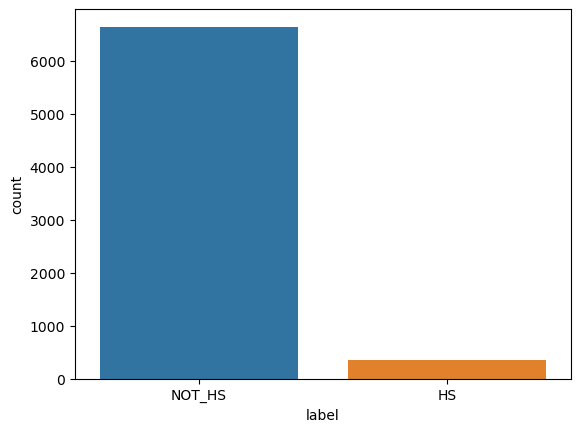

In [8]:
sns.countplot(x=train_data.Hate)
plt.xlabel('label')

Text(0.5, 0, 'label')

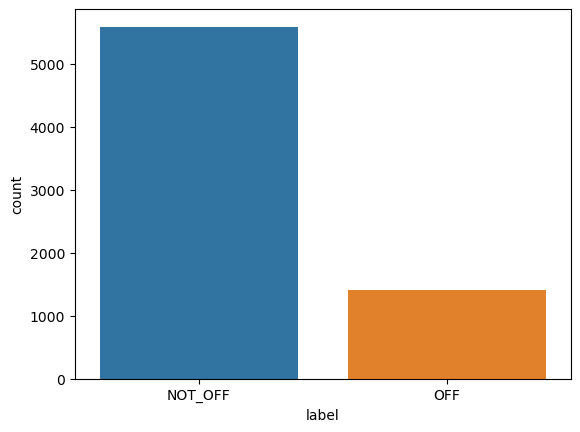

In [9]:
sns.countplot(x=train_data.Offensive)
plt.xlabel('label')

# Data Augmentation

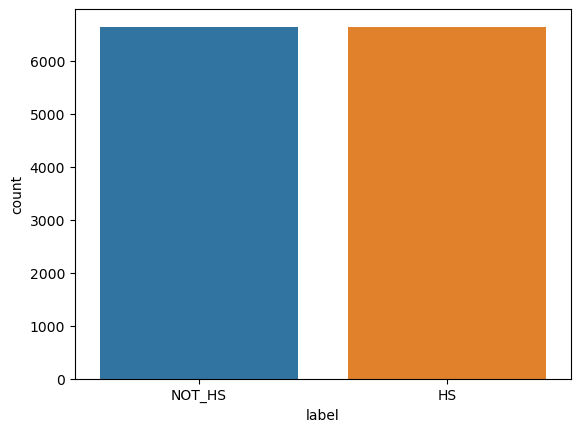

In [10]:
from imblearn.over_sampling import RandomOverSampler

X = train_data.drop('Hate', axis=1)
y = train_data['Hate']

ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X, y)

balanced_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['Hate'])], axis=1)

sns.countplot(x=balanced_data.Hate)
plt.xlabel('label')
plt.show()


# Data preprocessing

In [11]:
def clean(df):
    df = remove_diacritics(df)
    df = normalize_arabic(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df = remove_english_word_and_numbers(df)
    df = clean_space(df)
    df = remove_emoji(df)
    df = clean_space(df)
    df = clean_space(df)
    return df

In [12]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


In [13]:
def remove_diacritics(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x

def remove_punctuations(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_punctuations(x))
    return df
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_repeating_char(x))
    return df
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['Tweet'] = df["Tweet"].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)

def remove_emoji(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_emoji(x) if isinstance(x, str) else x)
    return df

def _remove_emoji(text):
    return emoji.get_emoji_regexp().sub(" ", text)



In [14]:
#train_data_cleaned = df_parallelize_run(balanced_data)
train_data_cleaned = clean(balanced_data)



In [15]:
test_data_cleaned = clean(dev_data)


In [16]:
train_data_cleaned.to_csv("train_data_cleaned.csv", index=False)
test_data_cleaned.to_csv("test_data_cleaned.csv", index=False)

In [17]:
print("TRAIN DATA")
print("tweets labeled as offensive and hate speech:\n", len(train_data_cleaned .query("Offensive == 'OFF' & Hate != 'NOT_HS'")))
print("tweets labeled as inoffensive and hate speech:\n", len(train_data_cleaned .query("Offensive == 'NOT_OFF' & Hate != 'NOT_HS'"))) # labels are well-maintained
print("tweets labeled as offensive only and not hate speech:\n", len(train_data_cleaned .query("Offensive == 'OFF' & Hate == 'NOT_HS'")))
print("tweets labeled as inoffensive and not hate speech:\n", len(train_data_cleaned .query("Offensive == 'NOT_OFF' & Hate == 'NOT_HS'")))

print("TEST DATA")

print("tweets labeled as offensive and hate speech:\n", len(test_data_cleaned .query("Offensive == 'OFF' & Hate != 'NOT_HS'")))
print("tweets labeled as inoffensive and hate speech:\n", len(test_data_cleaned .query("Offensive == 'NOT_OFF' & Hate != 'NOT_HS'"))) # labels are well-maintained
print("tweets labeled as offensive only and not hate speech:\n", len(test_data_cleaned .query("Offensive == 'OFF' & Hate == 'NOT_HS'")))
print("tweets labeled as inoffensive and not hate speech:\n", len(test_data_cleaned .query("Offensive == 'NOT_OFF' & Hate == 'NOT_HS'")))


TRAIN DATA
tweets labeled as offensive and hate speech:
 6639
tweets labeled as inoffensive and hate speech:
 0
tweets labeled as offensive only and not hate speech:
 1049
tweets labeled as inoffensive and not hate speech:
 5590
TEST DATA
tweets labeled as offensive and hate speech:
 44
tweets labeled as inoffensive and hate speech:
 0
tweets labeled as offensive only and not hate speech:
 135
tweets labeled as inoffensive and not hate speech:
 821


# Data preparation

In [18]:
def label_map(df):
    hate_mapping = {'HS': 1, 'NOT_HS': 0}
    offensive_mapping = {'OFF': 1, 'NOT_OFF': 0}

    # Apply the mappings
    df['Hate_binary'] = df['Hate'].map(hate_mapping)
    df['offensive_binary'] = df['Offensive'].map(offensive_mapping)

    
    df['labels'] = df.apply(lambda row: row['Hate_binary'] + row['offensive_binary'], axis=1)



    # Create a Hugging Face dataset
    new_df = Dataset.from_pandas(df[['Tweet', 'labels']])
    return new_df

In [19]:
train_dataset = label_map(train_data)
test_dataset = label_map(test_data_cleaned)



In [20]:
train_dataset.to_csv("train_dataset.csv", index=False)
test_dataset.to_csv("test_dataset.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

163671

# AraBart

In [21]:
from datasets import Dataset

train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')




train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = {
    'train': train_dataset,
    'test': test_dataset
}


In [22]:
max_length = train_df['Tweet'].apply(lambda x: len(x.split())).max()
print(max_length)

84


In [23]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

def preprocess_function(examples):
    return tokenizer(examples['Tweet'], truncation=True, padding='max_length', max_length=84)

# Tokenize the dataset
tokenized_datasets = {split: dataset[split].map(preprocess_function, batched=True) for split in dataset}


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [25]:
tokenized_datasets['train'][1]

{'Tweet': 'فدوه يا بخت فدوه يا زمن واحد منكم يجيبه',
 'labels': 0,
 'input_ids': [2,
  8324,
  1241,
  1955,
  2542,
  228,
  8324,
  1241,
  1955,
  3777,
  1411,
  16585,
  14788,
  195,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1

In [26]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02", num_labels=3)

# model = AutoModelForSequenceClassification.from_pretrained(
#     "aubmindlab/bert-base-arabertv02", 
#     num_labels=2,
#     problem_type="multi_label_classification"
# )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
save_directory = r"C:\Users\Mohamed\Arabic_Hate_Speech1"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

('C:\\Users\\Mohamed\\Arabic_Hate_Speech1\\tokenizer_config.json',
 'C:\\Users\\Mohamed\\Arabic_Hate_Speech1\\special_tokens_map.json',
 'C:\\Users\\Mohamed\\Arabic_Hate_Speech1\\vocab.txt',
 'C:\\Users\\Mohamed\\Arabic_Hate_Speech1\\added_tokens.json',
 'C:\\Users\\Mohamed\\Arabic_Hate_Speech1\\tokenizer.json')

In [28]:
from transformers import TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=3,
#     weight_decay=0.01,
# )
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)



In [29]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

# Use the compute_metrics function during evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

In [30]:
from transformers import Trainer

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_datasets['train'],
#     eval_dataset=tokenized_datasets['test'],
#     compute_metrics=compute_metrics,     
# )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,     

)

In [31]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.419400,0.317638,0.901000
2,0.241600,0.301023,0.925000
3,0.136300,0.370093,0.912000


TrainOutput(global_step=2625, training_loss=0.25636951119559154, metrics={'train_runtime': 282.8224, 'train_samples_per_second': 74.252, 'train_steps_per_second': 9.281, 'total_flos': 906507947016000.0, 'train_loss': 0.25636951119559154, 'epoch': 3.0})

In [32]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.3700930178165436, 'eval_accuracy': 0.912, 'eval_runtime': 3.2826, 'eval_samples_per_second': 304.633, 'eval_steps_per_second': 38.079, 'epoch': 3.0}


In [38]:
model_name = 'aubmindlab/bert-base-arabertv02'
num_labels = 3 

In [39]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

from transformers import AutoConfig, BertForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor, InputFeatures
from transformers import Trainer , TrainingArguments

In [41]:
config = AutoConfig.from_pretrained(model_name,num_labels=num_labels, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          do_lower_case=False,
                                          do_basic_tokenize=True)
tokenizer.max_len = 64
model = BertForSequenceClassification.from_pretrained(model_name, config=config)

train_dataset = SingleSentenceClassificationProcessor(mode='classification')
dev_dataset = SingleSentenceClassificationProcessor(mode='classification')

train_dataset.add_examples(texts_or_text_and_labels=train_df['Tweet'],labels=train_df['labels'],overwrite_examples = True)
dev_dataset.add_examples(texts_or_text_and_labels=test_df['Tweet'],labels=test_df['labels'],overwrite_examples = True)
print(train_dataset.examples[0])

train_features = train_dataset.get_features(tokenizer = tokenizer, max_length =64)
dev_features = dev_dataset.get_features(tokenizer = tokenizer, max_length =64)
# print(config)

print(len(train_features))
print(len(dev_features))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


InputExample(guid=None, text_a='الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم يا رجالة ⚪🔴<LF>الدوري يا زمالك .. الدوري يا زمالك<LF>#صدارة_بس', text_b=None, label=0)
7000
1000


In [46]:
def compute_metrics(p): #p should be of type EvalPrediction
    print(np.shape(p.predictions[0]))
    print(np.shape(p.predictions[1]))
    print(len(p.label_ids))
    preds = np.argmax(p.predictions[0], axis=1)
    assert len(preds) == len(p.label_ids)
    print(classification_report(p.label_ids,preds))
    print(confusion_matrix(p.label_ids,preds))

    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    macro_precision = precision_score(p.label_ids,preds,average='macro')
    macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }

In [47]:
training_args = TrainingArguments("./train")
training_args.do_train = True
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 2e-5
training_args.warmup_steps = 0
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 16
training_args.num_train_epochs = 3
training_args.logging_steps = 100
training_args.save_steps = 500
training_args.seed = 42
print(training_args.logging_steps)

100


In [48]:
# instantiate trainer
trainer = Trainer(model=model,
                  args = training_args,
                  train_dataset = train_features,
                  eval_dataset = dev_features,
                  compute_metrics = compute_metrics)


In [49]:
trainer.train()

Step,Training Loss
100,0.485900
200,0.369900
300,0.318700
400,0.311800
500,0.238500
600,0.207000
700,0.201800
800,0.236600
900,0.173500
1000,0.123000


TrainOutput(global_step=1314, training_loss=0.23502259838708098, metrics={'train_runtime': 164.5276, 'train_samples_per_second': 127.638, 'train_steps_per_second': 7.987, 'total_flos': 690672721536000.0, 'train_loss': 0.23502259838708098, 'epoch': 3.0})

In [50]:
trainer.evaluate()

(1000, 3)
(12, 1000, 12, 64, 64)
1000
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       821
           1       0.68      0.76      0.72       135
           2       0.63      0.55      0.59        44

    accuracy                           0.91      1000
   macro avg       0.76      0.75      0.76      1000
weighted avg       0.91      0.91      0.91      1000

[[786  31   4]
 [ 23 102  10]
 [  4  16  24]]


{'eval_loss': 0.29081860184669495,
 'eval_macro_f1': 0.755244005454346,
 'eval_macro_precision': 0.7609774578847871,
 'eval_macro_recall': 0.7527930543764892,
 'eval_accuracy': 0.912,
 'eval_runtime': 54.5759,
 'eval_samples_per_second': 18.323,
 'eval_steps_per_second': 1.154,
 'epoch': 3.0}